# Setup

In [227]:
%matplotlib inline

#interactive plotting in separate window to finetune 3D plots:
#%matplotlib qt 

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import pandas as pd

from pandas import DataFrame,Series,read_table

from mpl_toolkits.mplot3d import Axes3D
import sklearn.cluster

General info

In [228]:
savePlots = True    # whether or not to save plots
saveData = True     # whether or not to save csv files

saveAsPath = './Fig 08/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'Fig8'

In [229]:
# Path to CSVs with epoch-by-epoch variables
var_path = './Epoch-by-epoch_variables/' #'../data_copies/Epoch_variables/'
SW_path  = '../data_copies/SWs_EMs_and_EMartifacts/1s-epochs/'

In [230]:
birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['5 LEEGf-LEEGp', '6 LEEGm-LEEGp'],
                     ['5 LEEGf-LEEGm'], #, '4 LEEGf-Fgr'] this channel seems to have too much artifact
                     ['6LEEGm-LEEGp', '9REEGm-REEGp'],
                     ['9REEGf-REEGp', '6LEEGm-LEEGf'],
                     ['4LEEGf-LEEGp','7REEGf-REEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'


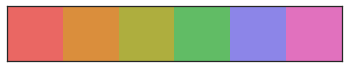

In [231]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

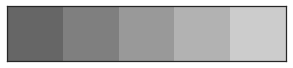

In [232]:
colors_birds = [np.repeat(.4, 3),
                np.repeat(.5, 3),
                np.repeat(.6, 3),
                np.repeat(.7, 3),
                np.repeat(.8, 3)]

sns.palplot(colors_birds)


Plot-specific info

In [233]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [234]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

birds = ['Bird 1', 'Bird 2', 'Bird 3', 'Bird 4', 'Bird 5']

In [235]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

# Load data

## pick 1 best channel per bird

In [236]:
EEGchannels_to_use = ['Bird 1: 6 LEEGm-LEEGp',
                      'Bird 2: 5 LEEGf-LEEGm',
                      'Bird 3: 9REEGm-REEGp',
                      'Bird 4: 6LEEGm-LEEGf',                     
                      'Bird 5: 7REEGf-REEGp']

## Import formatted scores

In [237]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores[bird_name] = data

## Import per-epoch variables

In [238]:
SleepVariables_raw = {}

for file in os.listdir(var_path):
    if file.endswith('.csv'):
        data = pd.read_csv(var_path + file, index_col=0)
        ch = file.split('_')[0].split('.')[0]   # get name of channel from filename
        
        if ch in EEGchannels_to_use:
            SleepVariables_raw[ch] = data

In [239]:
np.sort(list(SleepVariables_raw.keys()))

array(['Bird 1: 6 LEEGm-LEEGp', 'Bird 2: 5 LEEGf-LEEGm',
       'Bird 3: 9REEGm-REEGp', 'Bird 4: 6LEEGm-LEEGf',
       'Bird 5: 7REEGf-REEGp'], dtype='<U21')

### Load SWs and EMs

In [240]:
SWs_and_EMs = {}

for file in os.listdir(SW_path):
    if file.endswith('SW-EM-per-epoch.csv'):
        data = pd.read_csv(SW_path + file, index_col=0)
        bird = file.split('_')[1].split('.')[0]   # get name of channel from filename
        
        if 'LL' in bird:
            data['is sleep'] = data['Video Label (#)']==5
        else:
            data['is sleep'] = data['Label (#)']>2
            
        data['Epoch'] = data.index
        
        # take rolling sum and rolling mean of appropriate columns to get 3-s windows sliding by 1s
        #columns_to_sum = np.append(['EM s', 'SW s'], [x for x in data.columns if ('artifact' in x)|('SW s:' in x)])
        #data_3s = data[columns_to_sum].rolling(3, min_periods=1, center=True).sum()
    
        #columns_to_mean = ['EM med', 'EM mean', 'SW s all ch']
        #data_3s = data_3s.join(data[columns_to_mean].rolling(3, min_periods=1, center=True).mean())
        
        #columns_unchanged = [x for x in ['Video Label (#)', 'Label (#)', 'is sleep', 'Epoch'] if x in data.columns]
        #data_3s = data_3s.join(data.get(columns_unchanged))
        
        #SWs_and_EMs[bird] = data_3s
         
        SWs_and_EMs[bird] = data

In [241]:
# merge SWs/EMs with spectral variables

#EEGchannels = np.sort(list(SleepVariables_raw.keys()))

for ch in EEGchannels_to_use:

    bird = ch.split(':')[0]

    ChannelVariables = SleepVariables_raw[ch].copy()

    sleep_SW_EM = SWs_and_EMs[bird].copy().fillna(0) # replace NaNs with 0
    sleep_SW_EM = sleep_SW_EM[sleep_SW_EM["is sleep"]==1]

    ch_columns = [x for x in sleep_SW_EM.columns if ch[-9:] in x]
    ch_columns = np.append([ch_columns], ['SW s', 'SW s all ch', 'EM s', 'EM med', 'EM mean'])
    ch_SW_EM = sleep_SW_EM[ch_columns]

    BirdVariables = ChannelVariables.merge(ch_SW_EM, left_index=True, right_index=True)

    SleepVariables_raw[ch] = BirdVariables

# Remove high-amp artifacts

In [242]:
AllEpochs = pd.DataFrame([]) # init --> get number of epochs

nEpochs = pd.Series([])

for ch in EEGchannels_to_use:
    nEpochs.loc[ch] = len(SleepVariables_raw[ch])
        
AllEpochs['nEpochs'] = nEpochs

In [243]:
# amplitude thresholds calculated w/ below code:
# mean + 4SD of all EEG data
channel_artifact_thres = {
'Bird 1: 4 LEEGf-Fgr' : 334.6614824230419,
'Bird 1: 5 LEEGf-LEEGp' : 279.2679036087251,
'Bird 1: 6 LEEGm-LEEGp' : 465.24488691372113,
'Bird 1: 7 LEEGp-Fgr' : 320.5607548553074,
'Bird 1: 8 REEGp-Fgr' : 357.8599664737276,
'Bird 1: 9 REEGp-LEEGp' : 372.9954559400473,
'Bird 2: 4 LEEGf-Fgr' : 504.72536588215985,
'Bird 2: 5 LEEGf-LEEGm' : 260.6034616921849,
'Bird 2: 6 LEEGm-LEEGp' : 248.599520730528,
'Bird 2: 7 REEGf-Fgr' : 524.3624990659733,
'Bird 2: 8 REEGm-Fgr' : 563.8844002322004,
'Bird 2: 9 REEGf-REEGm' : 415.4251751631489,
'Bird 3: 4LEEGf-LEEGp' : 434.3907547931754,
'Bird 3: 5LEEGf-LEEGm' : 570.3830657447792,
'Bird 3: 6LEEGm-LEEGp' : 431.8025000446411,
'Bird 3: 7REEGf-REEGp' : 682.6618564103704,
'Bird 3: 8REEGf-REEGm' : 630.2331039533059,
'Bird 3: 9REEGm-REEGp' : 565.1595695127436,
'Bird 4: 4LEEGf-LEEGp' : 326.9907988688425,
'Bird 4: 5LEEGm-LEEGp' : 229.17181995825953,
'Bird 4: 6LEEGm-LEEGf' : 305.3846764062442,
'Bird 4: 7REEGf-Fgr' : 236.09867154982518,
'Bird 4: 8REEGf-REEGm' : 4358.523887351811,
'Bird 4: 9REEGf-REEGp' : 390.99383856831656,
'Bird 5: 4LEEGf-LEEGp' : 362.4612557939865,
'Bird 5: 5LEEGf-LEEGm' : 328.4858836553137,
'Bird 5: 6LEEGm-LEEGp' : 364.33228858586614,
'Bird 5: 7REEGf-REEGp' : 307.9690407823895,
'Bird 5: 8REEGf-REEGm' : 454.4356898143054,
'Bird 5: 9REEGm-REEGp' : 451.1410894025525
}

EEGdataAll = {}
TimeIndexEEG = {}
TimeIndexPower = {}

for b_num in birds: 
    
    b = int(b_num[5]) - 1   
        
##### arf files for all datasets except 4LL
    
    if '4LL' not in b_num:
    
        if 'LL' in b_num:
            arf_path = birdPaths_LL[b-1] + arfFilePaths_LL[b-1]
        else:
            arf_path = birdPaths[b] + arfFilePaths[b]

        for channel in channelsToLoadEEG[b]:
            all_data_array = np.array([])

            for file in np.sort(os.listdir(arf_path)):
                if file.endswith('.arf'):
                    arffile = h5py.File(arf_path+file, 'r')
                    data_array = arffile['.'][channel][()]
                    data_array = np.ndarray.flatten(data_array)

                    # Pad the end with NaN's to make it divisible by epoch length
                    nanPadding = np.zeros(epochLengthPts - np.mod(len(data_array), epochLengthPts))
                    nanPadding.fill(np.nan)
                    data_array = np.append(data_array,nanPadding)   

                    all_data_array = np.append(all_data_array,data_array)

            # Do not reshape

            # Save in dict under bird number and channel
            data_name = b_num + ': ' + channel
            EEGdataAll[data_name] = scalingFactor * all_data_array
    
##### bark files for 4LL

    elif '4LL' in b_num:
        if 'LL' in b_num:
            arf_path = birdPaths_LL[b-1] + arfFilePaths_LL[b-1]
        else:
            arf_path = birdPaths[b] + arfFilePaths[b]
        
        for channel in channelsToLoadEEG_best[b]:
            all_data_array = np.array([])

            for file in np.sort(os.listdir(arf_path)):
                if file.endswith('.dat'):
                    dset = bark.read_sampled(arf_path + file)

                    # get channel number
                    ch_num = [x for x in dset.attrs['columns'].keys() if channel in dset.attrs['columns'][x]['channel_name']]
                    if len(ch_num) != 1:
                        print("for bird", b_num, "channel", channel, ": correct number of channels not found")

                    data_array = dset.data[:, ch_num]
                    data_array = np.array(np.ndarray.flatten(data_array))  # flatten and take out of memmap modes

                    # Pad the end with NaN's to make it divisible by epoch length
                    nanPadding = np.zeros(epochLengthPts - np.mod(len(data_array), epochLengthPts))
                    nanPadding.fill(np.nan)
                    data_array = np.append(data_array,nanPadding)   

                    all_data_array = np.append(all_data_array,data_array)

                # Do not reshape

                # Save in dict under bird number and channel
                data_name = b_num + ': ' + channel
                EEGdataAll[data_name] = scalingFactor * all_data_array
    
##### Create time index for EEG

    all_time_array = np.array([], dtype='datetime64')
    for file in np.sort(os.listdir(arf_path)):
        if file.endswith('.arf')|file.endswith('.dat'):

            date = file.split('_')[2]

            if (b == 0) & ('2014-10-17' in file):
                hours = '17'
                minutes = '32'
            elif b == 0:
                hours = '09'
                minutes = '00'
            else:
                time = file.split('_')[3].split('.')[0]
                hours = time.split('-')[0]
                minutes = time.split('-')[1]

            datetime_start = np.datetime64(date + 'T' + hours + ':' + minutes + ':06')    # assume 6-s delay in starting recording

            # time index in datetime format
            
            if file.endswith('.arf'):
                arffile = h5py.File(arf_path+file, 'r')
                length_pts   = len(arffile['.'][channel][()])
            elif file.endswith('.dat'):
                length_pts   = len(bark.read_sampled(arf_path + file).data[:,0])
            
            padding_pts = epochLengthPts - np.mod(length_pts, epochLengthPts)
            length_s = (length_pts+padding_pts)/sr
            length_ms = np.timedelta64(int(1000 * length_s), 'ms')
            datetime_end = datetime_start + length_ms

            time_array = np.arange(datetime_start, datetime_end, np.timedelta64(int(1000/sr),'ms')) 

            # Add to end of whole-night time index
            all_time_array = np.append(all_time_array, time_array)


    
    TimeIndexEEG[b_num] = all_time_array
    
    # Get time at the start of each epoch
    TimeIndexPower[data_name] = all_time_array[np.arange(0,len(all_time_array),epochLengthPts)]
    

EEGchannels = np.sort(list(EEGdataAll.keys()))

# Set thresholds
artifact_threshold_SD  = 4   # of SDs away from mean

channel_artifact_thres = pd.Series([]) # init

for ch in EEGchannels:
    data = EEGdataAll[ch]

    # mean + N*SD
    artifact_threshold_SD_uV = (data[~np.isnan(data)]).mean() + artifact_threshold_SD*(data[~np.isnan(data)]).std()
    print(ch + ' : ' + str(artifact_threshold_SD_uV))
          
    # Save to dataframe
    channel_artifact_thres.loc[ch] = artifact_threshold_SD_uV
    

In [244]:
nEpochs_remaining = pd.Series([])
for ch in EEGchannels_to_use:
    ChannelVariables = SleepVariables_raw[ch].copy()
    
    # pull out only sleep rows
    sleep_data = ChannelVariables[ChannelVariables["is sleep"]==1]
    amp_thres = channel_artifact_thres[ch]
    
    # remove epochs with a max amplitude exceeding the threshold
    sleep_data = sleep_data[np.abs(sleep_data['max amp']) < amp_thres]
    
    SleepVariables_raw[ch] = sleep_data
    
    # Calc number of epochs remaining
    nEpochs_remaining.loc[ch] = len(sleep_data)
        
AllEpochs['nEpochs w/o max amp'] = nEpochs_remaining

# Dump EEG data so it's not staying in memory
EEGdataAll = None

# Remove EM artifacts

In [245]:
EM_artifact_thres = 1 # effectively, don't remove any

nEpochs_remaining = pd.Series([])
for ch in EEGchannels_to_use:

    ChannelVariables = SleepVariables_raw[ch].copy()

    EM_artifact_col = [x for x in ChannelVariables.columns if 'EM artifact s' in x]
    
    if len(EM_artifact_col) > 0:

        data = ChannelVariables[ChannelVariables[EM_artifact_col[0]] <= EM_artifact_thres]

        SleepVariables_raw[ch] = data

        nEpochs_remaining.loc[ch] = len(data)
        
        
        
AllEpochs['nEpochs w/o EM artifacts'] = nEpochs_remaining

###  z-score SleepVariables and pull out sleep data only

In [246]:
dont_z_score = ['Epoch', 'sleep scores', 'video scores', 'is sleep', 'is artifact']

channels = np.sort(list(SleepVariables_raw.keys()))
SleepVariables = {}

for ch in channels:
    b = int(ch[5]) - 1
    
    raw_data = SleepVariables_raw[ch].copy()
    
    # get sleep data only
    sleep_data = raw_data[(raw_data['is sleep'] == 1)]
                          #(raw_data['is artifact'] == 0)] # exclude artifact, wake, drowsy, and US epochs
    
    # get nighttime data only -- only makes senses for LD
    # if 'LL' not in ch:
        # sleep_data = sleep_data[(sleep_data['Epoch']>lightsOffEp[b]) &
        #                        (sleep_data['Epoch']<lightsOnEp[b])]
    
    tmp_data = sleep_data.copy()
    
    for variable in dont_z_score:
        if variable in sleep_data.columns.values:
            tmp_data = tmp_data.drop(variable, axis=1) # don't zscore these things
    
    # Zscore
    #tmp_data = tmp_data.fillna(0) # fill in any NaNs with 0
    for col in tmp_data.columns.values:
        col_data = tmp_data[col]
        col_data[~np.isnan(col_data)] = stat.zscore(col_data[~np.isnan(col_data)])
        
        tmp_data[col] = col_data
        
    # Add back in non-z-scored variables e.g.g Epoch # and manual scores
    
    for variable in dont_z_score:
        if variable in sleep_data.columns.values:
            tmp_data[variable] = sleep_data[variable]
    
    SleepVariables[ch] = tmp_data
    


### Calc how many epochs removed

In [247]:
AllEpochs

,nEpochs,nEpochs w/o max amp,nEpochs w/o EM artifacts
Bird 1: 6 LEEGm-LEEGp,33690,30708,30708
Bird 2: 5 LEEGf-LEEGm,30081,29441,29441
Bird 3: 9REEGm-REEGp,36189,36050,36050
Bird 4: 6LEEGm-LEEGf,41766,39875,39875
Bird 5: 7REEGf-REEGp,32589,31859,31859


In [248]:

print('mean % epochs removed by max amp cutoff')
perc_ep_rm = 100*((AllEpochs['nEpochs'] - AllEpochs['nEpochs w/o max amp'])/AllEpochs['nEpochs'])
print(np.mean(perc_ep_rm), '%  +/-', np.std(perc_ep_rm))

mean % epochs removed by max amp cutoff
3.626120093509634 %  +/- 2.92549789577036


In [249]:
print('mean % epochs removed by EM artifact cutoff')
perc_ep_rm = 100*((AllEpochs['nEpochs w/o max amp'] - AllEpochs['nEpochs w/o EM artifacts'])/AllEpochs['nEpochs'])
print(np.mean(perc_ep_rm), '%  +/-', np.std(perc_ep_rm))

mean % epochs removed by EM artifact cutoff
0.0 %  +/- 0.0


# 3D scatterplots

## 3D scatterplots: kmeans output

In [250]:
def scatter3D_kmeans(sleep_data, variableX, variableY, variableZ, 
                          which_scores='sleep scores',
                          stages=[3,5,4],
                          xlim=(-2,2), ylim=(-2,2), zlim=(-2,2),
                          angle1=45, angle2=225):
        
    bird_scores = sleep_data[which_scores]
    
##### Make scatterplot

    fig = plt.figure(figsize=(4,4))
    ax = fig.gca(projection='3d')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    ax.view_init(angle1, angle2)

    for clus in stages:
        # initialize
        tmp_StageX = np.zeros(len(bird_scores))
        tmp_StageX.fill(np.nan)
        tmp_StageY = np.zeros(len(bird_scores))
        tmp_StageY.fill(np.nan)
        tmp_StageZ = np.zeros(len(bird_scores))
        tmp_StageZ.fill(np.nan)

        # find stage inds
        tmp_indStage = np.where(bird_scores==clus)[0]
        # get variable for those stage inds

        tmp_StageX[tmp_indStage] = sleep_data[variableX].iloc[tmp_indStage]
        tmp_StageY[tmp_indStage] = sleep_data[variableY].iloc[tmp_indStage]
        tmp_StageZ[tmp_indStage] = sleep_data[variableZ].iloc[tmp_indStage]

        # Plot
        ax.scatter(tmp_StageX, tmp_StageY, tmp_StageZ, alpha = .8, c=[colors[clus]], lw=0, s=3)


    ax.set_xlabel('\n' + variableX) # add the newline to keep labels from overlapping ticklabels
    ax.set_ylabel('\n' + variableY)
    ax.set_zlabel('\n' + variableZ)


    plt.tight_layout()


In [251]:
def plot_Low_1c(ch, sleep_data, savePlots=savePlots):
    # Low et al Fig 1c
    variableX = "Delta"
    variableY = "GammaDeltaRatio"
    variableZ = "diffGammaDeltaRatio"
    xlim = (-5,5)
    ylim =(-5,5)
    zlim = (-5,15)

    angle1=33
    angle2=-133

    scatter3D_kmeans(sleep_data, variableX, variableY, variableZ,
                          which_scores='kmeans sleep scores',
                          xlim=xlim, ylim=ylim, zlim=zlim,
                          angle1=angle1, angle2=angle2)
    plt.title(ch)
    plt.tight_layout()

    if savePlots:
        birdNum = ch[5]
        name = saveAsPath + saveAsName + 'b-c,left_3Dscatter_LowFig1c_' + 'B' + birdNum + ch[9::]
        plt.savefig(name + '.tiff', dpi=300)

In [252]:
def plot_Low_1d(ch, sleep_data, savePlots=savePlots, 
                angle1=-160, angle2=-110):
    
    # Low et al Fig 1d
    variableX = "Delta"
    variableY = "GammaDeltaRatio"
    variableZ = "diffDelta"
    xlim = (-5,5)
    ylim =(-5,5)
    zlim = (-5,5)

    
    scatter3D_kmeans(sleep_data, variableX, variableY, variableZ,
                          which_scores='kmeans sleep scores',
                          xlim=xlim, ylim=ylim, zlim=zlim,
                          angle1=angle1, angle2=angle2)
    plt.title(ch)
    plt.tight_layout()

    if savePlots:
        birdNum = ch[5]
        name = saveAsPath + saveAsName + 'b-c,right_3Dscatter_LowFig1d_' + 'B' + birdNum + ch[9::]
        plt.savefig(name + '.tiff', dpi=300)

# PCA

In [253]:
# Run PCA
from sklearn.decomposition import PCA

def run_pca(sleep_data, variablesToUse, n_components=5, printout=False):
    data_for_pca = sleep_data[variablesToUse].fillna(0)
    pca = PCA(n_components=n_components)
    PCs = pca.fit_transform(data_for_pca)
    
    explained_variance = pca.explained_variance_ratio_
    if printout:
        print('Explained variance: ', explained_variance)
        
    # Z-score the first 5 PCs
    PCs = stat.zscore(PCs[:,0:5], axis=0)
        
    # Save to a dataframe
    PCs = pd.DataFrame(PCs, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5'])
    
    return(PCs, pca)

## 2D scatterplot: kmeans output

In [254]:
def scatter2D_kmeans(sleep_data, variableX, variableY, 
                          which_scores='sleep scores',
                          stages=[4,3,5], # specify order in which stages are plotted
                          xlim=(-2,2), ylim=(-2,2)):
        
    bird_scores = sleep_data[which_scores]
    
##### Make scatterplot

    #fig = plt.figure(figsize=(6,6))
    ax = plt.gca()

    for clus in stages:
        # initialize
        tmp_StageX = np.zeros(len(bird_scores))
        tmp_StageX.fill(np.nan)
        tmp_StageY = np.zeros(len(bird_scores))
        tmp_StageY.fill(np.nan)

        # find stage inds
        tmp_indStage = np.where(bird_scores==clus)[0]
        # get variable for those stage inds

        tmp_StageX[tmp_indStage] = sleep_data[variableX].iloc[tmp_indStage]
        tmp_StageY[tmp_indStage] = sleep_data[variableY].iloc[tmp_indStage]

        # Plot
        ax.scatter(tmp_StageX, tmp_StageY, alpha = .9, c=[colors[clus]], lw=0, s=3)


    ax.set_xlabel(variableX, fontsize=16) 
    ax.set_ylabel(variableY, fontsize=16)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    plt.tight_layout()
    sns.despine()

    #if savePlots:
    #    birdNum = ch[5]
    #    name = saveAsPath + saveAsName + '_2Dscatter_PCAs_' + 'B' + birdNum + ch[9::]
    #    plt.savefig(name + '.tiff', dpi=300)

## plot_pca

In [410]:
def plot_pca(ch, sleep_data, savePlots=savePlots,
    variablesToUse = ["GammaDeltaRatio", "diffGammaDeltaRatio", "SD",
                      "DeltaLog", "diffDelta"],
    PC1_flipped=False): 

    PCs, pca_object = run_pca(sleep_data, variablesToUse, n_components=5, printout=True)
    PCs['kmeans sleep scores'] = sleep_data['kmeans sleep scores'].values

    # 2D plots
    plt.figure(figsize=(10,3))
    variableX = "PC 1"
    variableY = "PC 2"
    variableZ = "PC 3"
    xlim = (-5,5)
    ylim =(-5,5)
    zlim = (-5,5)

    if (variableX == "PC 1") and PC1_flipped: # for birds where the first PC needs to be plotted from pos to neg
        xlim1 = (5, -5)
    else:
        xlim1 = xlim
        
    plt.subplot(1,3,1)
    scatter2D_kmeans(PCs, variableX, variableY,
                     stages=[4,5,3], # plot IS last
                          which_scores='kmeans sleep scores',
                          xlim=xlim1, ylim=ylim)
    plt.yticks([-5,0,5])

    plt.subplot(1,3,2)
    scatter2D_kmeans(PCs, variableX, variableZ,
                     stages=[4,5,3], # plot IS last
                          which_scores='kmeans sleep scores',
                          xlim=xlim1, ylim=ylim)
    plt.yticks([-5,0,5])


    plt.subplot(1,3,3)
    scatter2D_kmeans(PCs, variableY, variableZ,
                          which_scores='kmeans sleep scores',
                          xlim=xlim, ylim=ylim)
    plt.yticks([-5,0,5])
    
    #plt.suptitle(ch[0:6], fontsize=20)
    plt.tight_layout()
    if savePlots:
        birdNum = ch[5]
        name = saveAsPath + saveAsName + '_2Dscatter_LowFig1e_' + 'B' + birdNum + ch[9::]
        plt.savefig(name + '.tiff', dpi=300)

    # 3D plot
    plt.figure(figsize=(3,3))
    angle1=10
    angle2=50

    scatter3D_kmeans(PCs, variableX, 'PC 2', 'PC 3',
                          which_scores='kmeans sleep scores',
                          xlim=xlim, ylim=ylim, zlim=zlim,
                          angle1=angle1, angle2=angle2)
    plt.title(ch[0:6], fontsize=20)
    plt.tight_layout()
    if savePlots:
        birdNum = ch[5]
        name = saveAsPath + saveAsName + 'd-e_3Dscatter_PCAs_' + 'B' + birdNum + ch[9::]
        plt.savefig(name + '.tiff', dpi=300)

# Calculate concordance

In [256]:
def get_concordance_RvsN(manual_scores, auto_scores, every_3rd_score=True):
    
    manual_RvsN = manual_scores[manual_scores>2]# get sleep epochs only
    manual_RvsN[manual_RvsN==3] = 4 # change IS to the same number as SWS
    
    auto_RvsN   = auto_scores[manual_scores>2] # get sleep epochs only
    auto_RvsN[auto_RvsN==3] = 4 # change IS to the same number as SWS
    
    # at this point, both arrays should contain only 4's (NREM) or 5's (REM) or -1 (auto scores outlier)
    
    # take every 3rd score - use the middle score from each epoch
    #(ie if the auto scores are calculated with 1s epochs, whereas the manual scores are 3s epochs)
    if every_3rd_score:
        manual_RvsN = manual_RvsN[1::3]
        auto_RvsN = auto_RvsN[1::3]
    
    # calculate same vs different scores
    n_same_scores = np.sum(manual_RvsN==auto_RvsN)
    n_all_scores = len(manual_RvsN)
    
    concordance = n_same_scores/n_all_scores
    return(concordance)

In [257]:
def get_concordance_SvsN(manual_scores, auto_scores, every_3rd_score=True):
    
    manual_SvsN = manual_scores[manual_scores>2]# get sleep epochs only
    manual_SvsN[manual_SvsN==3] = 5 # change IS to the same number as REM
    
    auto_SvsN   = auto_scores[manual_scores>2] # get sleep epochs only
    auto_SvsN[auto_SvsN==3] = 5 # change IS to the same number as REM
    
    # at this point, both arrays should contain only 3's (SWS)) or 5's (NSWS) or -1 (auto scores outlier)
    
    # take every 3rd score - use the middle score from each epoch
    #(ie if the auto scores are calculated with 1s epochs, whereas the manual scores are 3s epochs)
    if every_3rd_score:
        manual_SvsN = manual_SvsN[1::3]
        auto_SvsN = auto_SvsN[1::3]
    
    # calculate same vs different scores
    n_same_scores = np.sum(manual_SvsN==auto_SvsN)
    n_all_scores = len(manual_SvsN)
    
    concordance = n_same_scores/n_all_scores
    return(concordance)

In [258]:
def get_concordance_IvsN(manual_scores, auto_scores, every_3rd_score=True):
    
    manual_IvsN = manual_scores[manual_scores>2]# get sleep epochs only
    manual_IvsN[manual_IvsN==4] = 5 # change SWS to the same number as REM
    
    auto_IvsN   = auto_scores[manual_scores>2] # get sleep epochs only
    auto_IvsN[auto_IvsN==4] = 5 # change IS to the same number as REM
    
    # at this point, both arrays should contain only 3's (IS)) or 5's (non-IS) or -1 (auto scores outlier)
    
    # take every 3rd score - use the middle score from each epoch
    #(ie if the auto scores are calculated with 1s epochs, whereas the manual scores are 3s epochs)
    if every_3rd_score:
        manual_IvsN = manual_IvsN[1::3]
        auto_IvsN = auto_IvsN[1::3]
    
    # calculate same vs different scores
    n_same_scores = np.sum(manual_IvsN==auto_IvsN)
    n_all_scores = len(manual_IvsN)
    
    concordance = n_same_scores/n_all_scores
    return(concordance)

# Calculate Cohen's kappa

In [259]:
def get_Cohens_kappa(manual_scores, auto_scores, every_3rd_score=True):
    manual_scores_sleep = manual_scores[manual_scores>2] # get sleep epochs only
    
    auto_scores_sleep   = auto_scores[manual_scores>2] # get sleep epochs only
    
    manual_scores_sleep = manual_scores_sleep.fillna(0)
    auto_scores_sleep = auto_scores_sleep.fillna(0)
    
    # take every 3rd score - use the middle score from each epoch
    #(ie if the auto scores are calculated with 1s epochs, whereas the manual scores are 3s epochs)
    if every_3rd_score:
        manual_scores_sleep = manual_scores_sleep[1::3]
        auto_scores_sleep = auto_scores_sleep[1::3]
        
    kappa = sklearn.metrics.cohen_kappa_score(manual_scores_sleep, auto_scores_sleep,
                                             labels=np.array([3,4,5])) # only consider IS, SWS, & REM    
    return(kappa)
        

In [260]:
def get_Cohens_kappa_RvsN(manual_scores, auto_scores, every_3rd_score=True):
    
    manual_RvsN = manual_scores[manual_scores>2]# get sleep epochs only
    manual_RvsN[manual_RvsN==3] = 4 # change IS to the same number as SWS
    
    auto_RvsN   = auto_scores[manual_scores>2] # get sleep epochs only
    auto_RvsN[auto_RvsN==3] = 4 # change IS to the same number as SWS
    
    manual_RvsN = manual_RvsN.fillna(0)
    auto_RvsN = auto_RvsN.fillna(0)
    
    # at this point, both arrays should contain only 4's (NREM) or 5's (REM) or -1 (auto scores outlier)
    
    # take every 3rd score - use the middle score from each epoch
    #(ie if the auto scores are calculated with 1s epochs, whereas the manual scores are 3s epochs)
    if every_3rd_score:
        manual_RvsN = manual_RvsN[1::3]
        auto_RvsN = auto_RvsN[1::3]
    
    kappa = sklearn.metrics.cohen_kappa_score(manual_RvsN, auto_RvsN,
                                             labels=np.array([4,5])) # only consider NREM & REM    
    return(kappa)


In [261]:
def get_Cohens_kappa_SvsN(manual_scores, auto_scores, every_3rd_score=True):
    
    manual_SvsN = manual_scores[manual_scores>2]# get sleep epochs only
    manual_SvsN[manual_SvsN==3] = 5 # change IS to the same number as REM
    
    auto_SvsN   = auto_scores[manual_scores>2] # get sleep epochs only
    auto_SvsN[auto_SvsN==3] = 5 # change IS to the same number as REM
    
    manual_SvsN = manual_SvsN.fillna(0)
    auto_SvsN = auto_SvsN.fillna(0)
    
    # at this point, both arrays should contain only 4's (SWS) or 5's (NSWS) or -1 (auto scores outlier)
    
    # take every 3rd score - use the middle score from each epoch
    #(ie if the auto scores are calculated with 1s epochs, whereas the manual scores are 3s epochs)
    if every_3rd_score:
        manual_SvsN = manual_SvsN[1::3]
        auto_SvsN = auto_SvsN[1::3]
    
    kappa = sklearn.metrics.cohen_kappa_score(manual_SvsN, auto_SvsN,
                                             labels=np.array([4,5])) # only consider SWS & NSWS    
    return(kappa)


# Calc sensitivity & specificity

In [341]:
def get_sens_and_spec(manual_scores, auto_scores, stage, every_3rd_score=True):
    manual = manual_scores[manual_scores>2]# get sleep epochs only
    
    auto   = auto_scores[manual_scores>2] # get sleep epochs only
    
    manual = manual.fillna(0)
    auto   = auto.fillna(0)
    
    # take every 3rd score - use the middle score from each epoch
    #(ie if the auto scores are calculated with 1s epochs, whereas the manual scores are 3s epochs)
    if every_3rd_score:
        manual = manual[1::3]
        auto = auto[1::3]
    
    # get true pos, false pos, true neg, and false neg
    TP = np.sum((manual==stage)&(auto==stage))
    FP = np.sum((manual!=stage)&(auto==stage))
    TN = np.sum((manual!=stage)&(auto!=stage))
    FN = np.sum((manual==stage)&(auto!=stage))
    
    # sens and spec
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    
    return(sensitivity, specificity)
    

# print_concordance

In [342]:
get_sens_and_spec(sleep_data['sleep scores'], 
                                        sleep_data['kmeans sleep scores'], every_3rd_score=False,
                                        stage=5)

(0.7390321121664405, 0.7725396480556159)

In [344]:
def print_concordance(ch, sleep_data, every_3rd_score=False, print_output=True):

    same_scores = len(sleep_data[(sleep_data["sleep scores"]==sleep_data["kmeans sleep scores"]) & (~np.isnan(sleep_data["kmeans scores 1"]))])
    all_scores = len(sleep_data[~np.isnan(sleep_data["kmeans scores 1"])])
    concordance = same_scores/all_scores

    if print_output:
        print("Concordance = " + '\t' + str(concordance))

    kappa = get_Cohens_kappa(sleep_data['sleep scores'], 
                                        sleep_data['kmeans sleep scores'], every_3rd_score=every_3rd_score)

    if print_output:
        print("Cohen's kappa = " + str(kappa))

    concordance_REMvsNREM = get_concordance_RvsN(sleep_data['sleep scores'], 
                                        sleep_data['kmeans sleep scores'], every_3rd_score=every_3rd_score)

    if print_output:
        print("REM vs NREM concordance = " + '\t' + str(concordance_REMvsNREM))

    kappa_REMvsNREM = get_Cohens_kappa_RvsN(sleep_data['sleep scores'], 
                                        sleep_data['kmeans sleep scores'], every_3rd_score=every_3rd_score)

    if print_output:
        print("REM vs NREM kappa = " + '\t\t' + str(kappa_REMvsNREM))

    concordance_SWSvsNSWS = get_concordance_SvsN(sleep_data['sleep scores'], 
                                        sleep_data['kmeans sleep scores'], every_3rd_score=every_3rd_score)

    if print_output:
        print("SWS vs NSWS concordance = " +  str(concordance_SWSvsNSWS))
        
    kappa_SWSvsNSWS = get_Cohens_kappa_SvsN(sleep_data['sleep scores'], 
                                        sleep_data['kmeans sleep scores'], every_3rd_score=every_3rd_score)

    if print_output:
        print("SWS vs NSWS kappa = " + '\t' + str(kappa_SWSvsNSWS))
        
        
    concordance_ISvsNon = get_concordance_IvsN(sleep_data['sleep scores'], 
                                        sleep_data['kmeans sleep scores'], every_3rd_score=every_3rd_score)

    if print_output:
        print("IS vs nonIS concordance = " +  str(concordance_ISvsNon))
        
    ######### SENSITIVITY and SPECIFICITY #########    
    sensitivity_REM, specificity_REM = get_sens_and_spec(sleep_data['sleep scores'], 
                                        sleep_data['kmeans sleep scores'], every_3rd_score=False,
                                        stage=5)
    if print_output:
        print("REM sensitivity = " + str(sensitivity_REM))
        print("REM specificity = " + str(specificity_REM))

    sensitivity_SWS, specificity_SWS = get_sens_and_spec(sleep_data['sleep scores'], 
                                        sleep_data['kmeans sleep scores'], every_3rd_score=False,
                                        stage=4)
    if print_output:
        print("SWS sensitivity = " + str(sensitivity_SWS))
        print("SWS specificity = " + str(specificity_SWS))
    
    concordances = pd.DataFrame({"Concordance": concordance,
                                 "Cohen's kappa": kappa,
                                 "REM vs NREM concordance": concordance_REMvsNREM,
                                 "REM vs NREM kappa": kappa_REMvsNREM,
                                 "SWS vs NSWS concordance": concordance_SWSvsNSWS,
                                 "SWS vs NSWS kappa": kappa_SWSvsNSWS,
                                 "IS vs nonIS concordance": concordance_ISvsNon,
                                 "REM sensitivity": sensitivity_REM,
                                 "REM specificity": specificity_REM,
                                 "SWS sensitivity": sensitivity_SWS,
                                 "SWS specificity": specificity_SWS
                                 },
                               index=[ch])
    return(concordances)


# plotHypnogram_SleepOnly

In [345]:
def plotHypnogram_SleepOnly(sleep_data, ScoresVariable="sleep scores",
                            reindex=True,
                            plot_xlabels=True, ylabel=ch, alpha=0.1,
                            epLength_s=1):
    #b = int(ch[5]) - 1
    
    xlim_min = 0

    Scores = sleep_data[[ScoresVariable, 'Epoch']]
    stages = ['i','s','r']
    stage_nums = [3, 4, 5]
    colors_kmeans = colors[3:6]
    
    # reindex: cluster all the sleep epochs together
    if reindex:
        Scores = Scores.reset_index() #[ScoresVariable]

    xlim_max = np.max(Scores.index.values)

    # for each stage, make a vlines plot
    for st in range(len(stages)):
        stage_scores = Scores[Scores[ScoresVariable]==stage_nums[st]]
        plt.vlines(stage_scores.index.values, -st, -st - 1, 
               color=colors_kmeans[st], alpha=alpha)

    # vertical lines at lights on and off
    birdNum = int(ch[5]) - 1
    lightsOff_xloc = Scores[Scores['Epoch']>lightsOffEp[birdNum]].index[0]
    lightsOn_xloc = Scores[Scores['Epoch']>lightsOnEp[birdNum]].index[0]
    plt.axvline(lightsOff_xloc, color='k', alpha = 0.5)
    plt.axvline(lightsOn_xloc, color='k', alpha = 0.5)

    # labels of each stage
    plt.yticks(-0.5 - np.arange(len(stages)), stages)
    ax=plt.gca()
    for ytick, color in zip(ax.get_yticklabels(), colors_kmeans):
        ytick.set_color(color)

    # axis labels    
    plt.ylabel(ylabel)
    if plot_xlabels:
        plt.xlabel('hours of sleep')
        plt.xticks(np.arange(xlim_min, xlim_max, 3600/epLength_s),
                   np.arange(xlim_min, xlim_max, 3600/epLength_s)/(3600/epLength_s)) # x axis in hours
    else:
        plt.xticks([])
        
    sns.despine()

    # limits
    plt.xlim(xlim_min, xlim_max)
    

# make_plots

In [346]:
def make_plots(ch, sleep_data, alpha=0.02, savePlots=False):

    plt.figure(figsize=(10,4))
    plt.subplot(2,1,1)
    plotHypnogram_SleepOnly(sleep_data, "sleep scores", ylabel="Manual", alpha=alpha, plot_xlabels=False)
    
    plt.subplot(2,1,2)
    plotHypnogram_SleepOnly(sleep_data, "kmeans sleep scores", ylabel="Kmeans", alpha=alpha)
    plt.suptitle(ch)

    if savePlots:
        birdNum = ch[5]
        name = saveAsPath + saveAsName + 'a_hypnogram_manual_v_kmeans_' + ch
        plt.savefig(name + '.tiff', dpi=300)

# Cluster

## **** cluster_v4.2 - FIGURE

In [347]:
def cluster_v4_2(bird, which_ch, print_output=False):

    ##### 1. Run k-means clustering 1: SWS vs NSWS (using Delta)

    # get data from each ch
    for n, ch in enumerate(which_ch):

        ChannelVariables = SleepVariables[bird + ': ' + ch].copy()
        
        variablesToUse = ["DeltaLog", "diffDelta", "diffGammaDeltaRatio", "SD",
                          "max amp", 'nPeaks'] #, "SW s all ch"] #, "Delta"]   #"SW s all ch"

        if n==0:
            # pull out only sleep rows
            sleep_data = ChannelVariables[variablesToUse][ChannelVariables["is sleep"]==1] 
        else:
            tmp_sleep_data = ChannelVariables[variablesToUse][ChannelVariables["is sleep"]==1]
            sleep_data = sleep_data.join(tmp_sleep_data,lsuffix='_1', rsuffix='_2', how='outer')
            
    sleep_data = sleep_data.fillna(0) # fill in any NaNs with 0 - this effectively sets missing values as average

    # run kmeans
    n_clusters = 2
    centroid, label, inertia = sklearn.cluster.k_means(sleep_data, n_clusters)

    sleep_data['kmeans scores 1'] = label

    # Save kmeans cluster IDs 

    kmeans_scores_1 = sleep_data['kmeans scores 1'].copy()


    if print_output:
        print("Percentage assigned to cluster 1 vs 0: ", np.sum(label)/len(label))

    ##### 2. Run k-means clustering 2: REM vs NREM (using Gamma/Delta)


    # get data from each ch
    for n, ch in enumerate(which_ch):
        variablesToUse = ["GammaDeltaRatio", "diffDelta","diffGammaDeltaRatio","SD",
                          "nPeaks"] #, "EM s"] # "EM artifact s: " + ch, "EM med"] #, "EM s"]

        ChannelVariables = SleepVariables[bird + ': ' + ch].copy()

        if n==0:
            # pull out only sleep rows
            sleep_data = ChannelVariables[variablesToUse][ChannelVariables["is sleep"]==1] 
        else:
            tmp_sleep_data = ChannelVariables[variablesToUse][ChannelVariables["is sleep"]==1]
            sleep_data = sleep_data.join(tmp_sleep_data, lsuffix='_1', rsuffix='_2', how='outer')

    sleep_data = sleep_data.fillna(0) # fill in any NaNs with 0 - this effectively sets missing values as average

    n_clusters = 2
    centroid, label, inertia = sklearn.cluster.k_means(sleep_data, n_clusters)

    sleep_data['kmeans scores 2'] = label

    # Save kmeans cluster IDs 
    kmeans_scores_2 = sleep_data['kmeans scores 2'].copy()

    if print_output:
        print("Percentage assigned to cluster 1 vs 0: ", np.sum(label)/len(label))

    ##### 3. Classify epochs based on double clustering
    #* SWS + nREM = SWS
    #* nSWS + nREM = IS
    #* nSWS + REM  = REM
    #* SWS + REM  = ?

    # get data from each ch & take average (not including NaNs) - this is to assign cluster IDs
    for n, ch in enumerate(which_ch):

        # pull out only sleep data
        ch_sleep_data = SleepVariables[bird + ': ' + ch].copy()
        ch_sleep_data = ch_sleep_data[ch_sleep_data["is sleep"]==1] 

        if n == 0:
            sleep_data = ch_sleep_data
        else:
            sleep_data = pd.concat((sleep_data, ch_sleep_data), sort=True)

    sleep_data = sleep_data.groupby(sleep_data.index).mean() ## method for averaging/combining over channels

    sleep_data['kmeans scores 1'] = kmeans_scores_1
    sleep_data['kmeans scores 2'] = kmeans_scores_2


    # For kmeans 1, the higher delta cluser is SWS
    clus0_delta = sleep_data[sleep_data['kmeans scores 1']==0]['DeltaLog'].mean()
    clus1_delta = sleep_data[sleep_data['kmeans scores 1']==1]['DeltaLog'].mean()
    if clus0_delta > clus1_delta:
        SWS  = 0
        nSWS = 1
    else:
        SWS  = 1
        nSWS = 0

    # For kmeans 2, the higher gamma cluser is REM
    clus0_gamma = sleep_data[sleep_data['kmeans scores 2']==0]['GammaDeltaRatio'].mean()
    clus1_gamma = sleep_data[sleep_data['kmeans scores 2']==1]['GammaDeltaRatio'].mean()

    if clus0_gamma > clus1_gamma:
        REM  = 0
        nREM = 1
    else:
        REM  = 1
        nREM = 0

    if print_output:
        print('SWS: cluster {} \nREM: cluster {}'.format(SWS, REM))

    kmeans1 = sleep_data["kmeans scores 1"]
    kmeans2 = sleep_data["kmeans scores 2"]

    kmeans_sleep_scores = np.zeros(len(sleep_data))

    inds_sws = np.where( (kmeans1==SWS) & (kmeans2==nREM))[0]
    inds_is  = np.where( (kmeans1==nSWS)& (kmeans2==nREM))[0]
    inds_rem = np.where( (kmeans1==nSWS)& (kmeans2==REM))[0]
    inds_nan = np.where( (kmeans1==SWS) & (kmeans2==REM))[0]

    ##### Smooth scores: put IS in the middle

    kmeans_sleep_scores[inds_sws] = 3
    kmeans_sleep_scores[inds_is] = 4
    kmeans_sleep_scores[inds_rem] = 5

    # Put artifact epochs as -1, will undo soon
    kmeans_sleep_scores[inds_nan] = -1

    #### Add back non-sleep epochs by reindexing
    kmeans_sleep_scores = pd.Series(kmeans_sleep_scores, index=sleep_data.index)

    new_index = np.arange(np.min(sleep_data.index.values), np.max(sleep_data.index.values))
    kmeans_sleep_scores = kmeans_sleep_scores.reindex(new_index).fillna(4)  #### Give non-sleep epochs same value as IS

    # Replace artifact epochs with NaN
    kmeans_sleep_scores[kmeans_sleep_scores==-1] = np.nan

    #### Smooth

    kmeans_scores_smoothed = kmeans_sleep_scores.rolling(window=5, min_periods=1, center=True).mean()

    # Get rid of wake epochs
    kmeans_scores_smoothed = kmeans_scores_smoothed[sleep_data.index]

    # Replace NaNs with -1 (just to allow rounding; will undo this later)
    kmeans_scores_smoothed = kmeans_scores_smoothed.fillna(-1)

    # Round:
    kmeans_scores_smoothed = np.round(kmeans_scores_smoothed).astype('int')

    # Switch IS and SWS numbers to align with the manual scores (IS=3, SWS=4)

    kmeans_scores = kmeans_scores_smoothed.copy()
    kmeans_scores[kmeans_scores_smoothed==3] = 4
    kmeans_scores[kmeans_scores_smoothed==4] = 3

    # Replace -1 with Nan
    kmeans_scores[kmeans_scores_smoothed==-1] = np.nan


    # Get totals of each stage

    sleep_data['kmeans sleep scores'] = kmeans_scores

    inds_sws = np.sum(kmeans_scores==4)
    inds_rem = np.sum(kmeans_scores==5)
    inds_is  = np.sum(kmeans_scores==3)
    inds_nan = np.sum(np.isnan(kmeans_scores))
    nIndsSleep = inds_sws + inds_rem + inds_is + inds_nan



    if print_output:
        print('% SWS: \t', inds_sws/nIndsSleep)
        print('% REM: \t', inds_rem/nIndsSleep)
        print('% IS: \t',  inds_is/nIndsSleep)
        print('% artifact: \t', inds_nan/nIndsSleep)

    return(sleep_data)

In [348]:
AllSleepData = {}
AllSleepData_LL = {}
AllConcordances = pd.DataFrame([])

### Bird 1

In [404]:
ch = 'Bird 1: 6 LEEGm-LEEGp'

In [405]:
bird = ch.split(':')[0]
which_ch = [ch.split(':')[1][1::]]
sleep_data = cluster_v4_2(bird, which_ch, print_output=True)

Percentage assigned to cluster 1 vs 0:  0.4507945812166211
Percentage assigned to cluster 1 vs 0:  0.4257196821675133
SWS: cluster 1 
REM: cluster 1
% SWS: 	 0.361143675915071
% REM: 	 0.34280969128565847
% IS: 	 0.29601406799531066
% artifact: 	 3.2564803959880164e-05


/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [406]:
concordances = print_concordance(ch, sleep_data, every_3rd_score=True)


Concordance = 	0.5706981893968999
Cohen's kappa = 0.36080258027108836
REM vs NREM concordance = 	0.7543962485345839
REM vs NREM kappa = 		0.487628708047545
SWS vs NSWS concordance = 0.761430246189918
SWS vs NSWS kappa = 	0.426569908161027
IS vs nonIS concordance = 0.6266119577960141
REM sensitivity = 0.611730380788509
REM specificity = 0.86448301712704
SWS sensitivity = 0.8076479314323389
SWS specificity = 0.748792662635445


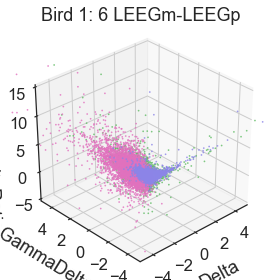

In [407]:
plot_Low_1c(ch, sleep_data, savePlots=savePlots)

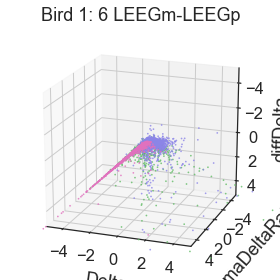

In [408]:
plot_Low_1d(ch, sleep_data, savePlots=savePlots)

Explained variance:  [0.45303261 0.20983158 0.1938969  0.11093904 0.03229986]


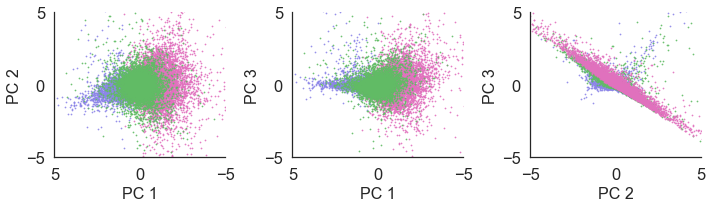

<Figure size 216x216 with 0 Axes>

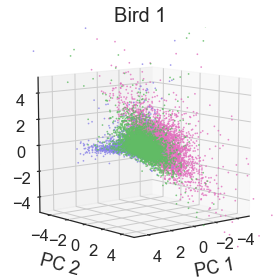

In [411]:
plot_pca(ch, sleep_data, savePlots=savePlots, PC1_flipped=True)

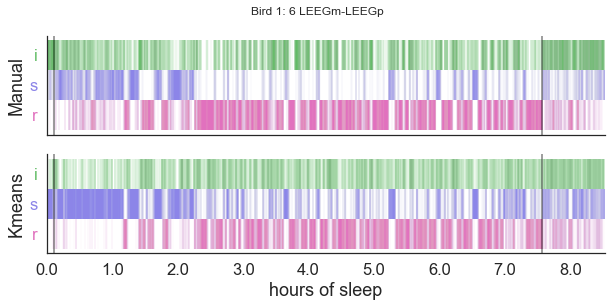

In [355]:
make_plots(ch, sleep_data, alpha=0.02, savePlots=savePlots)

In [356]:
AllConcordances = AllConcordances.append(concordances)
AllSleepData[ch] = sleep_data

### Bird 2

In [357]:
ch = 'Bird 2: 5 LEEGf-LEEGm'

In [358]:
bird = ch.split(':')[0]
which_ch = [ch.split(':')[1][1::]]
sleep_data = cluster_v4_2(bird, which_ch, print_output=True)

Percentage assigned to cluster 1 vs 0:  0.2978499371624605
Percentage assigned to cluster 1 vs 0:  0.3914608878774498
SWS: cluster 1 
REM: cluster 1
% SWS: 	 0.20451071634795015
% REM: 	 0.3004313712170103
% IS: 	 0.49498997995991983
% artifact: 	 6.793247511973099e-05


/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [359]:
concordances = print_concordance(ch, sleep_data, every_3rd_score=True)


Concordance = 	0.501511497571414
Cohen's kappa = 0.18315498356098536
REM vs NREM concordance = 	0.6921744446708783
REM vs NREM kappa = 		0.3059458478103305
SWS vs NSWS concordance = 0.7496433666191156
SWS vs NSWS kappa = 	0.10137282221858301
IS vs nonIS concordance = 0.5597106174852252
REM sensitivity = 0.4899061700312767
REM specificity = 0.8053996823716252
SWS sensitivity = 0.3156744948115784
SWS specificity = 0.811280499631483


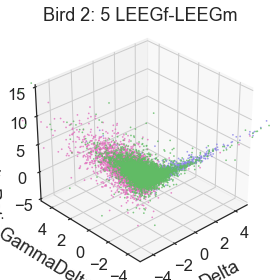

In [360]:
plot_Low_1c(ch, sleep_data)

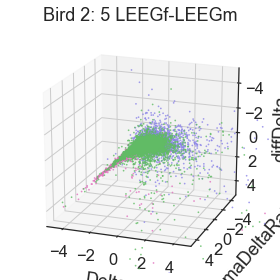

In [361]:
plot_Low_1d(ch, sleep_data)

Explained variance:  [0.38380079 0.24154879 0.17614871 0.16350747 0.03499423]


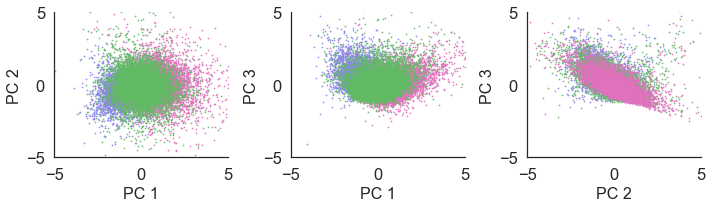

<Figure size 216x216 with 0 Axes>

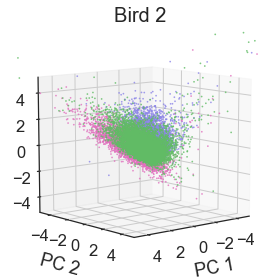

In [362]:
plot_pca(ch, sleep_data)

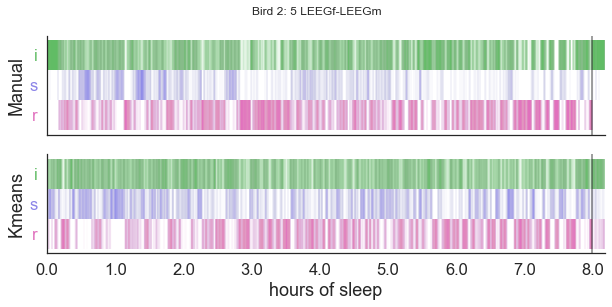

In [363]:
make_plots(ch, sleep_data, alpha=0.02)

In [364]:
AllConcordances = AllConcordances.append(concordances)
AllSleepData[ch] = sleep_data


### Bird 3

In [365]:
# Exemplar channel
ch = 'Bird 3: 9REEGm-REEGp'

In [366]:
bird = ch.split(':')[0]
which_ch = [ch.split(':')[1][1::]]
sleep_data = cluster_v4_2(bird, which_ch, print_output=True)

Percentage assigned to cluster 1 vs 0:  0.491872399445215
Percentage assigned to cluster 1 vs 0:  0.16477115117891816
SWS: cluster 0 
REM: cluster 1
% SWS: 	 0.48438280166435504
% REM: 	 0.12330097087378641
% IS: 	 0.39209431345353674
% artifact: 	 0.00022191400832177532


/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [367]:
concordances = print_concordance(ch, sleep_data, every_3rd_score=True)


Concordance = 	0.5333980582524271
Cohen's kappa = 0.25490036486012413
REM vs NREM concordance = 	0.8831655155196805
REM vs NREM kappa = 		0.553357371706844
SWS vs NSWS concordance = 0.624282266788716
SWS vs NSWS kappa = 	0.23375927951007103
IS vs nonIS concordance = 0.5444786552384122
REM sensitivity = 0.5397692774741955
REM specificity = 0.9698255379811282
SWS sensitivity = 0.7494021397105097
SWS specificity = 0.5905354919053549


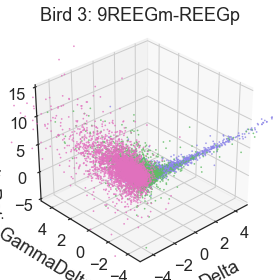

In [368]:
plot_Low_1c(ch, sleep_data, savePlots=savePlots)

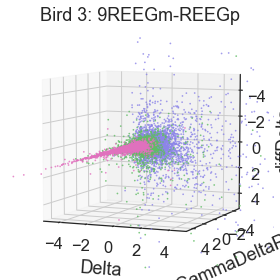

In [369]:
plot_Low_1d(ch, sleep_data, angle1=-173, angle2=-113, savePlots=savePlots)

Explained variance:  [0.38862531 0.23619166 0.17001723 0.15745254 0.04771326]


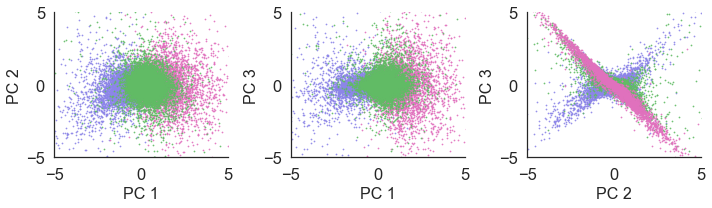

<Figure size 216x216 with 0 Axes>

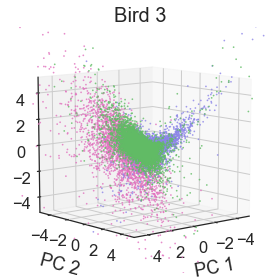

In [370]:
plot_pca(ch, sleep_data, savePlots=savePlots)

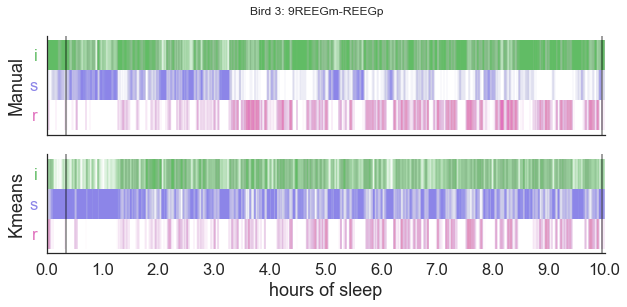

In [371]:
make_plots(ch, sleep_data, alpha=0.02)

In [372]:
AllConcordances = AllConcordances.append(concordances)
AllSleepData[ch] = sleep_data


### Bird 4

In [412]:
# Exemplar channel
ch = 'Bird 4: 6LEEGm-LEEGf'

In [413]:
bird = ch.split(':')[0]
which_ch = [ch.split(':')[1][1::]]
sleep_data = cluster_v4_2(bird, which_ch, print_output=True)

Percentage assigned to cluster 1 vs 0:  0.1015423197492163
Percentage assigned to cluster 1 vs 0:  0.6650282131661442
SWS: cluster 1 
REM: cluster 0
% SWS: 	 0.06761128526645768
% REM: 	 0.28772413793103446
% IS: 	 0.6446394984326019
% artifact: 	 2.5078369905956112e-05


/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [414]:
concordances = print_concordance(ch, sleep_data, every_3rd_score=True)


Concordance = 	0.5635611285266457
Cohen's kappa = 0.2564933527115113
REM vs NREM concordance = 	0.7904002407463135
REM vs NREM kappa = 		0.44591070514732045
SWS vs NSWS concordance = 0.7267529340956966
SWS vs NSWS kappa = 	0.08504357367268611
IS vs nonIS concordance = 0.6120222690340054
REM sensitivity = 0.6823487796250443
REM specificity = 0.8188825890297509
SWS sensitivity = 0.11448663853727145
SWS specificity = 0.9495035946593632


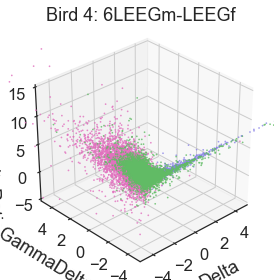

In [415]:
plot_Low_1c(ch, sleep_data)

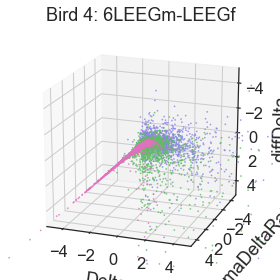

In [416]:
plot_Low_1d(ch, sleep_data)

Explained variance:  [0.38900386 0.22040089 0.18221249 0.16467696 0.0437058 ]


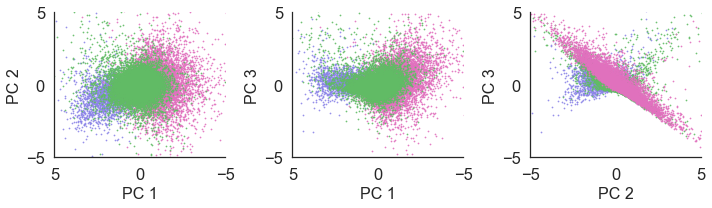

<Figure size 216x216 with 0 Axes>

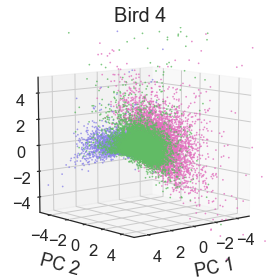

In [418]:
plot_pca(ch, sleep_data, PC1_flipped=True)

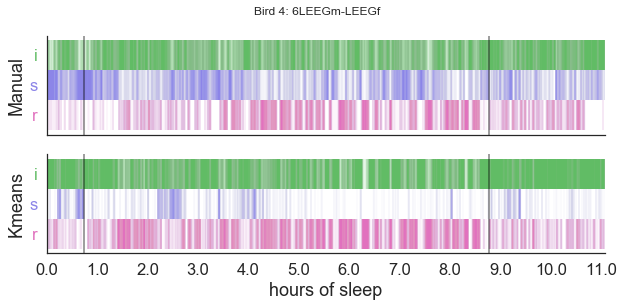

In [379]:
make_plots(ch, sleep_data, alpha=0.02)

In [380]:
AllConcordances = AllConcordances.append(concordances)
AllSleepData[ch] = sleep_data


### Bird 5

In [381]:
ch = 'Bird 5: 7REEGf-REEGp'

In [382]:
bird = ch.split(':')[0]
which_ch = [ch.split(':')[1][1::]]
sleep_data = cluster_v4_2(bird, which_ch, print_output=True)

Percentage assigned to cluster 1 vs 0:  0.4151731065005179
Percentage assigned to cluster 1 vs 0:  0.5301798549860322
SWS: cluster 1 
REM: cluster 0
% SWS: 	 0.31269029159735084
% REM: 	 0.37276750682695625
% IS: 	 0.31451081327097524
% artifact: 	 3.13883047176622e-05


/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [383]:
concordances = print_concordance(ch, sleep_data, every_3rd_score=True)


Concordance = 	0.51087604758467
Cohen's kappa = 0.2691700732018808
REM vs NREM concordance = 	0.7599811676082863
REM vs NREM kappa = 		0.4595095372637258
SWS vs NSWS concordance = 0.7188323917137477
SWS vs NSWS kappa = 	0.2386188674765768
IS vs nonIS concordance = 0.5412429378531074
REM sensitivity = 0.7414066033469019
REM specificity = 0.7688898544427547
SWS sensitivity = 0.6044995794785534
SWS specificity = 0.7385160314356344


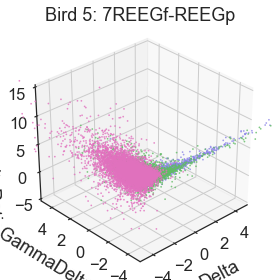

In [384]:
plot_Low_1c(ch, sleep_data, savePlots=savePlots)

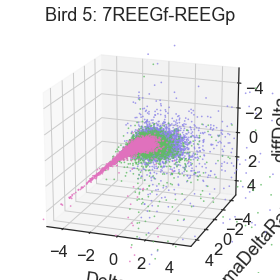

In [385]:
%matplotlib inline
plot_Low_1d(ch, sleep_data, savePlots=savePlots)

Explained variance:  [0.42680047 0.24793117 0.160276   0.13131382 0.03367854]


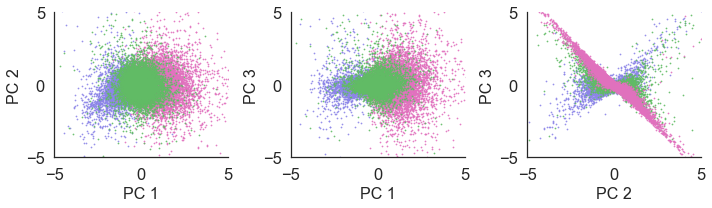

<Figure size 216x216 with 0 Axes>

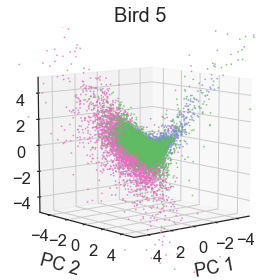

In [386]:
plot_pca(ch, sleep_data, savePlots=savePlots)

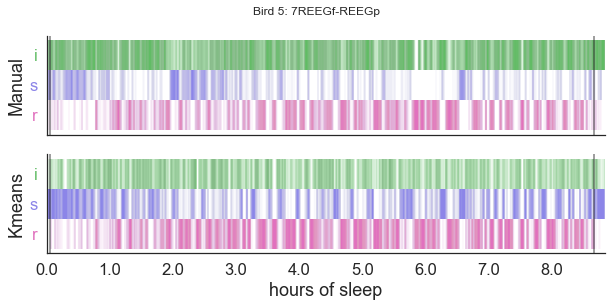

In [387]:
make_plots(ch, sleep_data, alpha=0.02)

In [388]:
AllConcordances = AllConcordances.append(concordances)
AllSleepData[ch] = sleep_data


# Results of auto-scoring

## Concordances

In [389]:
AllConcordances.mean()

Concordance                0.536478
Cohen's kappa              0.265281
REM vs NREM concordance    0.776532
REM vs NREM kappa          0.451144
SWS vs NSWS concordance    0.716314
SWS vs NSWS kappa          0.217239
IS vs nonIS concordance    0.577021
REM sensitivity            0.612635
REM specificity            0.846387
SWS sensitivity            0.518050
SWS specificity            0.767864
dtype: float64

In [390]:
print("SEMs")
AllConcordances.std()/np.sqrt(5)

SEMs


Concordance                0.014023
Cohen's kappa              0.028550
REM vs NREM concordance    0.031205
REM vs NREM kappa          0.040640
SWS vs NSWS concordance    0.024289
SWS vs NSWS kappa          0.061583
IS vs nonIS concordance    0.017907
REM sensitivity            0.045547
REM specificity            0.034521
SWS sensitivity            0.131829
SWS specificity            0.058063
dtype: float64

In [391]:
print("SDs")
AllConcordances.std()

SDs


Concordance                0.031355
Cohen's kappa              0.063841
REM vs NREM concordance    0.069778
REM vs NREM kappa          0.090873
SWS vs NSWS concordance    0.054313
SWS vs NSWS kappa          0.137704
IS vs nonIS concordance    0.040042
REM sensitivity            0.101847
REM specificity            0.077192
SWS sensitivity            0.294780
SWS specificity            0.129833
dtype: float64

In [392]:
print('test example when all automated scores = REM:')
test = sleep_data.copy()
test['kmeans sleep scores'] = 5
concordances = print_concordance(ch, test, every_3rd_score=False)


test example when all automated scores = REM:
Concordance = 	0.2775981669230045
Cohen's kappa = 0.0
REM vs NREM concordance = 	0.2775981669230045
REM vs NREM kappa = 		0.0
SWS vs NSWS concordance = 0.8507172227627986
SWS vs NSWS kappa = 	0.0
IS vs nonIS concordance = 0.4268809441602059
REM sensitivity = 1.0
REM specificity = 0.0
SWS sensitivity = 0.0
SWS specificity = 1.0


### save to csv

In [393]:
if saveData:
    AllConcordances.to_csv(saveAsPath + saveAsName + '_concordances.csv')

## Scores

In [394]:
AllProportionsManual = pd.DataFrame([])
AllProportionsAuto   = pd.DataFrame([])

for ch in list(AllSleepData.keys()):

    counts_manual = AllSleepData[ch]['sleep scores'].value_counts(sort=False)
    counts_auto = AllSleepData[ch]['kmeans sleep scores'].value_counts(sort=False)

    proportions_manual = counts_manual/(counts_manual.sum())
    proportions_auto   = counts_auto/(counts_auto.sum())
    
    AllProportionsManual[ch] = proportions_manual
    AllProportionsAuto[ch]   = proportions_auto
    
    print(ch + "____________________________________________")
    #print(proportions_manual)
    print(proportions_auto)
    


Bird 1: 6 LEEGm-LEEGp____________________________________________
4.0    0.360081
3.0    0.297294
5.0    0.342625
Name: kmeans sleep scores, dtype: float64
Bird 2: 5 LEEGf-LEEGm____________________________________________
5.0    0.300452
3.0    0.495024
4.0    0.204525
Name: kmeans sleep scores, dtype: float64
Bird 3: 9REEGm-REEGp____________________________________________
4.0    0.484490
5.0    0.123328
3.0    0.392181
Name: kmeans sleep scores, dtype: float64
Bird 4: 6LEEGm-LEEGf____________________________________________
4.0    0.067839
5.0    0.284220
3.0    0.647941
Name: kmeans sleep scores, dtype: float64
Bird 5: 7REEGf-REEGp____________________________________________
4.0    0.312700
3.0    0.314521
5.0    0.372779
Name: kmeans sleep scores, dtype: float64


i Ttest_relResult(statistic=1.2461462341477785, pvalue=0.2807098128785709)
s Ttest_relResult(statistic=-1.1911018039912045, pvalue=0.2994605766534657)
r Ttest_relResult(statistic=0.2263566825754363, pvalue=0.8320206190495701)


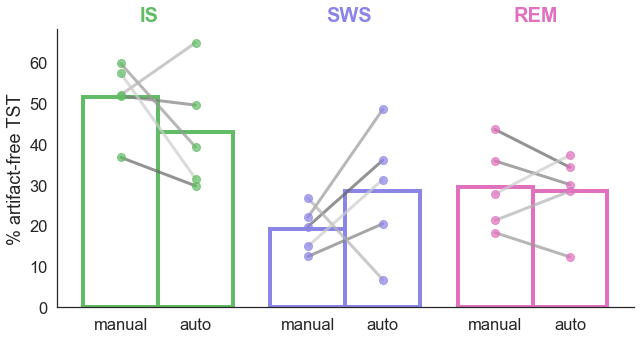

In [395]:
plt.figure(figsize=(9,4.5))
for ch in list(AllSleepData.keys()):
    b = int(ch[5]) - 1
    proportions_manual = AllProportionsManual[ch]
    proportions_auto = AllProportionsAuto[ch]
    for st in [3,4,5]:
        # lines colored by bird
        plt.plot([st, st+.4], [proportions_manual[st], proportions_auto[st]], color=colors_birds[b], lw=3,alpha=.7)
        # dots colored by stage
        plt.plot([st, st+.4], [proportions_manual[st], proportions_auto[st]], 
                                'o', alpha=.7, color=colors[st], markersize=8)
       
        
for st in [3,4,5]:
    plt.bar([st, st+.4], [AllProportionsManual.loc[st].mean(), 
                          AllProportionsAuto.loc[st].mean()],
                         width=.4, color='none', edgecolor=colors[st], linewidth=4)
     # t-test
    print(stages[st], stat.ttest_rel(AllProportionsManual.loc[st], AllProportionsAuto.loc[st]))
    
plt.ylabel('% artifact-free TST')
plt.xticks([3, 3.4, 4, 4.4, 5, 5.4], ['manual', 'auto','manual', 'auto','manual', 'auto'])

plt.yticks(np.arange(0, .7, .1), np.arange(0, 70, 10))

sns.despine()
plt.tight_layout()
plt.text(3.1, 0.7, 'IS', fontsize=20, fontweight='bold', color=colors[3]);
plt.text(4.1, 0.7, 'SWS', fontsize=20, fontweight='bold', color=colors[4]);
plt.text(5.1, 0.7, 'REM', fontsize=20, fontweight='bold', color=colors[5]);

In [396]:
print('Manual scores: means')
AllProportionsManual.mean(axis=1)

Manual scores: means


4.0    0.191817
3.0    0.514842
5.0    0.293341
dtype: float64

In [397]:
print('Automated scores: means')

AllProportionsAuto.mean(axis=1)

Automated scores: means


4.0    0.285927
3.0    0.429392
5.0    0.284681
dtype: float64

In [398]:
print('Automated scores: SDs')

AllProportionsAuto.std(axis=1)

Automated scores: SDs


4.0    0.157981
3.0    0.145001
5.0    0.096699
dtype: float64

### save to csv

In [399]:
if saveData:
    AllProportionsAuto.to_csv(saveAsPath + saveAsName + '_automated_scores.csv')
    AllProportionsManual.to_csv(saveAsPath + saveAsName + '_manual_scores.csv')

## "Artifact" scores (ie both SWS and REM)

In [400]:
print('Artifacts before score smoothing: % of epochs')

perc_artifacts = []
for ch in AllSleepData.keys():
    sleep_data = AllSleepData[ch]
    
    # For kmeans 1, the higher delta cluser is SWS
    clus0_delta = sleep_data[sleep_data['kmeans scores 1']==0]['DeltaLog'].mean()
    clus1_delta = sleep_data[sleep_data['kmeans scores 1']==1]['DeltaLog'].mean()
    if clus0_delta > clus1_delta:
        SWS  = 0
        nSWS = 1
    else:
        SWS  = 1
        nSWS = 0

    # For kmeans 2, the higher gamma cluser is REM
    clus0_gamma = sleep_data[sleep_data['kmeans scores 2']==0]['GammaDeltaRatio'].mean()
    clus1_gamma = sleep_data[sleep_data['kmeans scores 2']==1]['GammaDeltaRatio'].mean()

    if clus0_gamma > clus1_gamma:
        REM  = 0
        nREM = 1
    else:
        REM  = 1
        nREM = 0
        
    nArtifacts = np.sum((sleep_data['kmeans scores 1']==SWS)&(sleep_data['kmeans scores 2']==REM))
    nTotal = sum(~np.isnan(sleep_data['kmeans scores 1']))
    
    print(ch + '_______________')
    print('number of artifact epochs:', nArtifacts)
    print('% of total epochs:',  nArtifacts/nTotal)
    
    perc_artifacts.append(100*nArtifacts/nTotal)

Artifacts before score smoothing: % of epochs
Bird 1: 6 LEEGm-LEEGp_______________
number of artifact epochs: 397
% of total epochs: 0.012928227172072424
Bird 2: 5 LEEGf-LEEGm_______________
number of artifact epochs: 750
% of total epochs: 0.02547467816989912
Bird 3: 9REEGm-REEGp_______________
number of artifact epochs: 157
% of total epochs: 0.0043550624133148405
Bird 4: 6LEEGm-LEEGf_______________
number of artifact epochs: 220
% of total epochs: 0.005517241379310344
Bird 5: 7REEGf-REEGp_______________
number of artifact epochs: 395
% of total epochs: 0.012398380363476569


In [401]:
print('Mean artifacts before smoothing (%)')
print(np.mean(perc_artifacts))
print('SD:')
print(np.std(perc_artifacts))

Mean artifacts before smoothing (%)
1.213471789961466
SD:
0.7522868466953119


In [402]:
print('Artifacts after smoothing: # epochs')

for ch in AllSleepData.keys():
    sleep_data = AllSleepData[ch]
    print(ch)
    print(np.sum(np.isnan(sleep_data['kmeans sleep scores'])))

Artifacts after smoothing: # epochs
Bird 1: 6 LEEGm-LEEGp
1
Bird 2: 5 LEEGf-LEEGm
2
Bird 3: 9REEGm-REEGp
8
Bird 4: 6LEEGm-LEEGf
1
Bird 5: 7REEGf-REEGp
1
